In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import argparse, cv2, logging, pdb
import focus_stacking.registration.ecc as ecc
import focus_stacking.utils.images as im_utils
import focus_stacking.utils.data_loader as data_loader
from focus_stacking.utils.pyramids import StackPyramid, Pyramid
import focus_stacking.utils.pyramids
import focus_stacking.energy.energy as energies
import focus_stacking.fusion.fusion as fusion
import focus_stacking.pipelines.scale_transform_pipeline as scale_transform
import focus_stacking.pipelines.simple_pipeline as simple_pipeline

align_max_iters = 50
align_eps = 1e-3
DATA_ROOT = '/n/fs/3d-indoor/macro_data/focus_stacks'

logger = logging.getLogger(__name__)


In [2]:
aux_out_dir = '/n/fs/3d-indoor/tmp_outdir/aux/'
registered_images = data_loader.load_images_from_dir(aux_out_dir, match='reg_*.jpg')

In [3]:
ENERGIES = ['local_variance', 'local_entropy', 'local_region', 'laplacian', 'self', 'squared']
FUSION_STRATEGIES = ['max', 'multi_max', 'multi_max_vote', 'min']
SCALE_TRANSFORMS = ['laplacian_pyramid', 'wavelet']
PIPELINES = ['simple', 'scale_transform']

parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)
parser.add_argument('--data.obj', type=str, help='top level object directory', dest='obj')
parser.add_argument('--data.view', type=str, help='view dir, formatted as 03:d', dest='view')
parser.add_argument('--data.fnum', choices=['f4.0', 'f5.6', 'f6.3', 'f13', 'f22'], type=str, help='aperture size', dest='fnum')
parser.add_argument('--data.src_dir', type=str, help='manually specify full path to image source directory', dest='src_dir')

parser.add_argument('--register.load', action='store_true', help='if true, load registered images from aux dir and skip alignment', dest='load_reg_images')
parser.add_argument('--register.save_images', action='store_true', help='write registered images to aux output directory', dest='reg_save_im')
parser.add_argument('--register.ref_im_idx', type=int, help='reference image to align image to', dest='ref_im_idx', default=0)
parser.add_argument('--register.res', type=int, help='downscale image by [res] for warping only', dest='warp_res', default=1)
parser.add_argument('--register.max_iters', type=int, help='max iterations for ECC', dest='align_max_iters', default=50)
parser.add_argument('--register.eps', type=float, help='termination eps for ECC', dest='align_eps', default=1e-3)

parser.add_argument('--pipeline', type=str, choices=PIPELINES)

parser.add_argument('--simple.energies', nargs='+', choices=ENERGIES, dest='simple_energies')
parser.add_argument('--simple.fusion', choices=FUSION_STRATEGIES, dest='simple_fusion')

parser.add_argument('--scale_transform.type', type=str, choices=SCALE_TRANSFORMS, help='energies used for pyramid base fusion', dest='st_type')
parser.add_argument('--scale_transform.wavelet_name', type=str, help='energies used for pyramid base fusion', dest='st_wavelet_name')
parser.add_argument('--scale_transform.reassign_ch', action='store_true', dest='st_reassign_ch')
parser.add_argument('--scale_transform.kwidth', type=int, help='kernel width for pyramid construction', default=63, dest='st_kwidth')
parser.add_argument('--scale_transform.depth', type=int, help='pyramid depth/number of levels in pyramid', default=5, dest='st_depth')
parser.add_argument('--scale_transform.base_energies', nargs='+', choices=ENERGIES, help='energies used for pyramid base fusion', dest='st_base_energies')
parser.add_argument('--scale_transform.base_fusion', choices=FUSION_STRATEGIES, help='energies used for pyramid base fusion', dest='st_base_fusion')
parser.add_argument('--scale_transform.level_energies', nargs='+', choices=ENERGIES, help='energies used for pyramid base fusion', dest='st_level_energies')
parser.add_argument('--scale_transform.level_fusion',  choices=FUSION_STRATEGIES, help='energies used for pyramid base fusion', dest='st_level_fusion')

parser.add_argument('--energy.variance.neighborhood', type=int, dest='energy_variance_neighborhood')
parser.add_argument('--energy.entropy.neighborhood', type=int, dest='energy_entropy_neighborhood')
parser.add_argument('--energy.region.neighborhood', type=int, dest='energy_region_neighborhood')
parser.add_argument('--energy.region.kwidth', type=int, dest='energy_region_kwidth')
parser.add_argument('--energy.laplacian.neighborhood', type=int)
parser.add_argument('--energy.laplacian.kwidth', type=int)

parser.add_argument('--out_dir', type=str, help='manually specify output directory')
parser.add_argument('--out_fname', type=str, default='fused_im.jpg')
parser.add_argument('--aux_out_dir', type=str, help='manually specify auxiliary output directory')
parser.add_argument('--results_out_dir', type=str, help='manually specify results output directory')
#subparsers = parser.add_subparsers(dest='method')

_StoreAction(option_strings=['--results_out_dir'], dest='results_out_dir', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='manually specify results output directory', metavar=None)

In [20]:
cmd_line = ['--data.obj', 'snail',
            '--data.view', '000',
            '--data.fnum', 'f4.0',
            '--pipeline', 'scale_transform',
            '--scale_transform.type', 'wavelet',
            '--scale_transform.wavelet_name', 'db16',
            '--scale_transform.depth', '5',
            '--scale_transform.base_energies', 'local_variance',
            '--scale_transform.base_fusion', 'multi_max',
            '--scale_transform.reassign_ch',
            '--scale_transform.level_energies', 'squared',
            '--scale_transform.level_fusion', 'multi_max_vote',
            '--energy.variance.neighborhood', '9',
            '--aux_out_dir', '/n/fs/3d-indoor/tmp_outdir/aux',
            ]
args = parser.parse_args(cmd_line)

In [ ]:
fused_im, stacks, recon_pyramids = scale_transform.run_wavelet_pipeline(args, registered_images)

-0.2995972 1.1807824
0.0 1.0
-0.5976292 1.1523439
0.0 1.0


In [6]:
import matplotlib.pyplot as plt


In [ ]:
plt.imshow(im_utils.bgr_to_rgb(fused_im))

In [ ]:
cv2.imwrite('wavelet_mine_depth5_avg_base.png', fused_im)

In [31]:
base_ims = [pyramid.levels[-1]['image'] for pyramid in stacks[0].pyramids]
base_ims[0].shape

(67, 85)

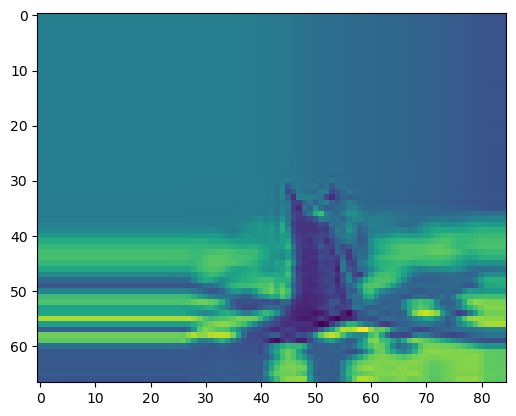

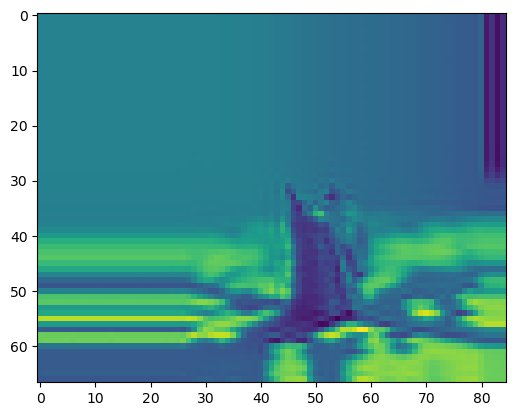

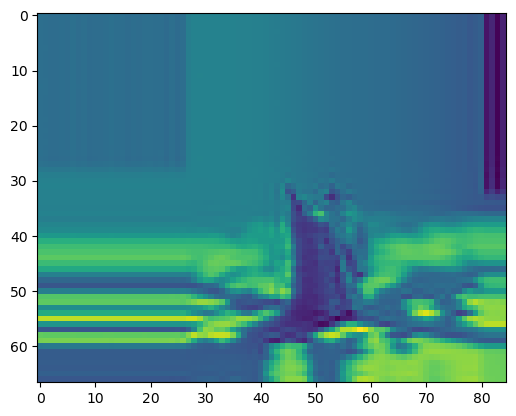

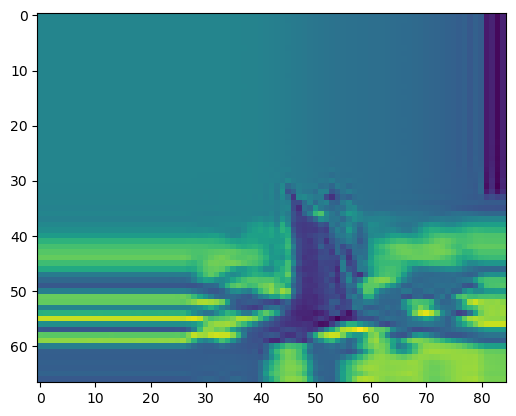

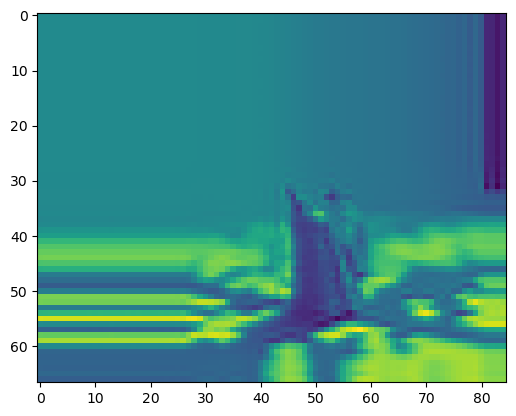

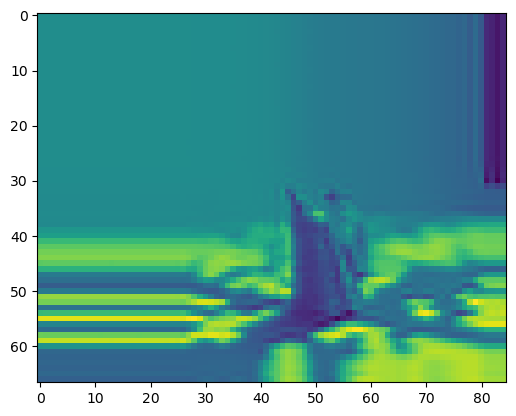

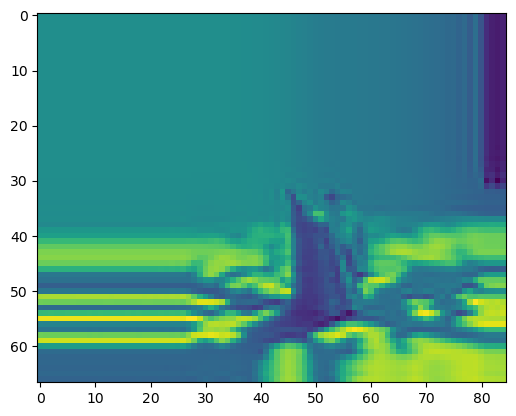

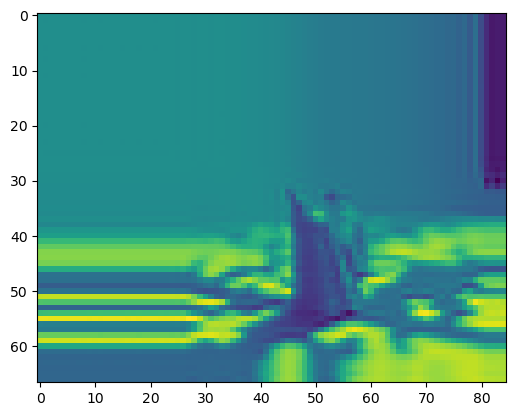

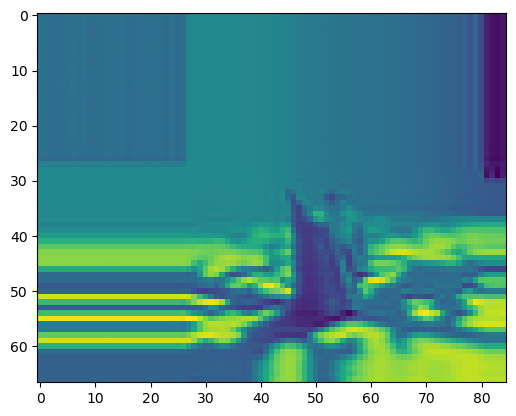

In [32]:
for base_im in base_ims:
    plt.imshow(base_im)
    plt.show()

In [79]:
energies.local_variance

<function focus_stacking.energy.energy.local_variance(im, neighborhood, im_color=True)>

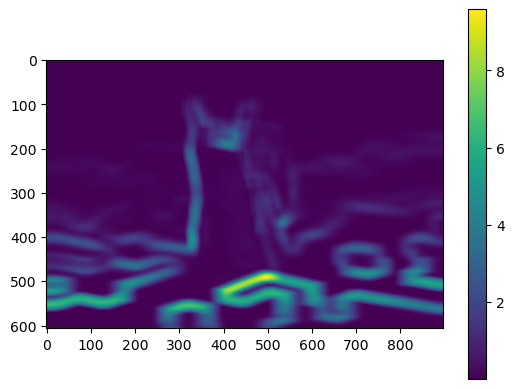

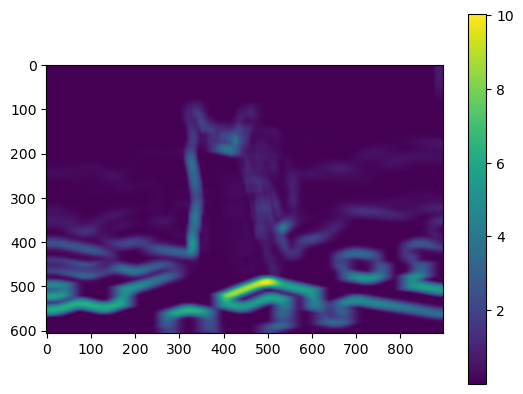

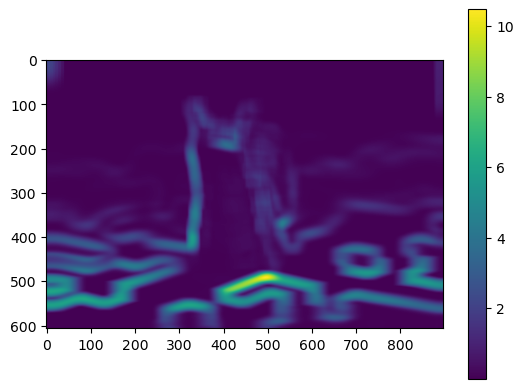

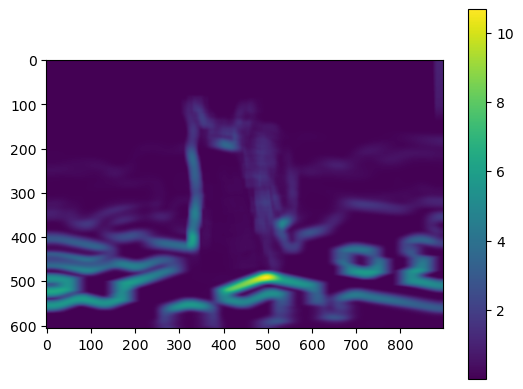

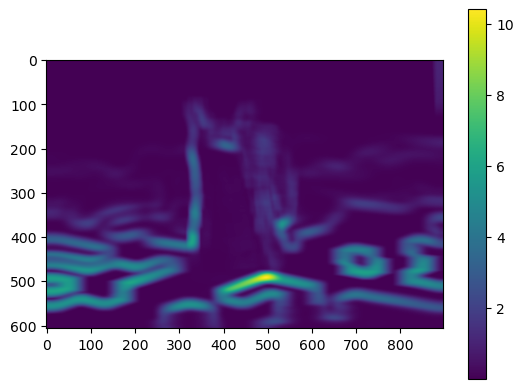

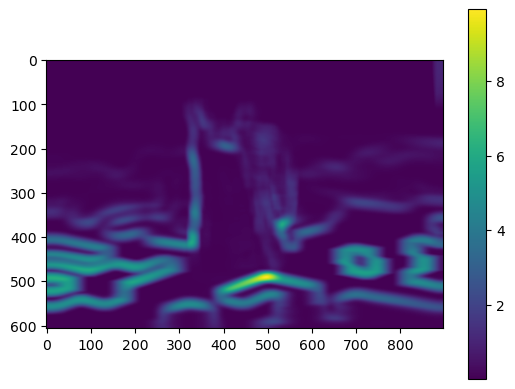

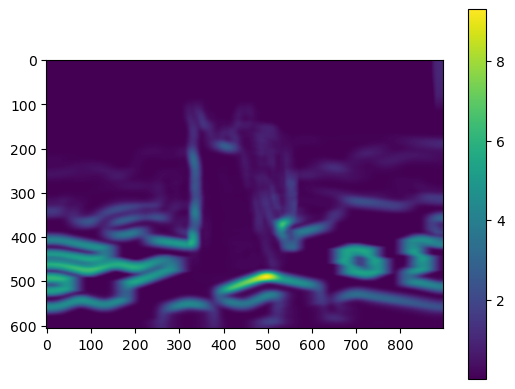

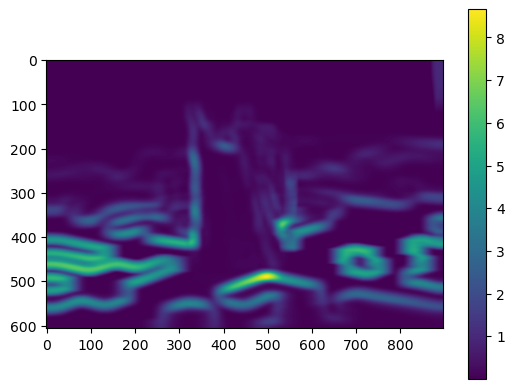

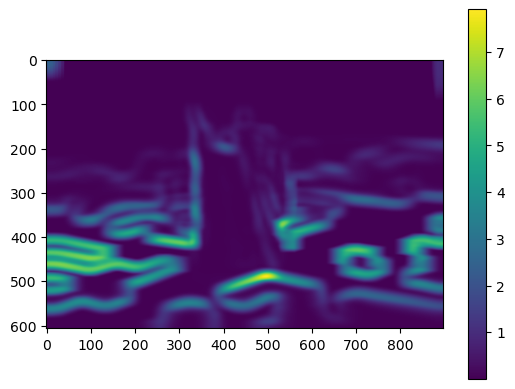

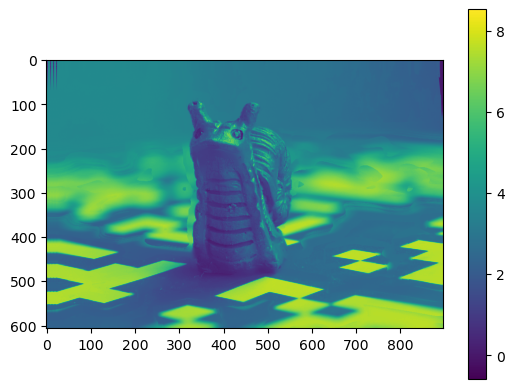

In [98]:
variances = []
for base_im in base_ims:
    var = energies.local_variance(base_im, 35, im_color=False)
    variances.append(var)
    plt.imshow(var)
    plt.colorbar()
    plt.show()
fused_base = fusion.fuse_max(variances, [base_im[...,np.newaxis] for base_im in base_ims])
plt.imshow(fused_base)
plt.colorbar()

In [92]:
fused_base = fusion.fuse_max(variances, [base_im[...,np.newaxis] for base_im in base_ims])

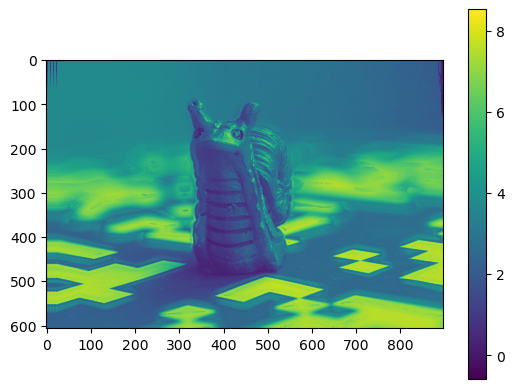

In [94]:
plt.imshow(fused_base)
plt.colorbar()

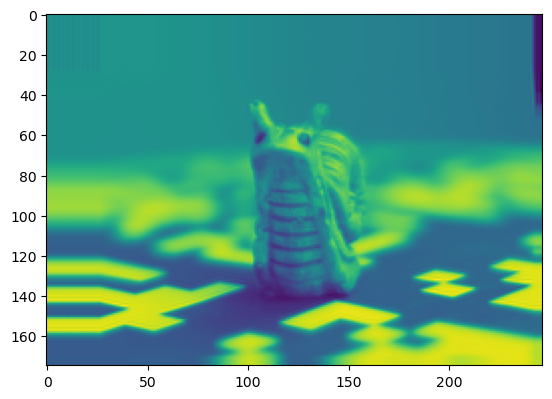

In [71]:
plt.imshow(np.mean(np.stack([pyramid.levels[-1]['image'][...,np.newaxis] for pyramid in stacks[2].pyramids]),axis=0))

In [64]:
recon_0 = recon_pyramids[0].reconstruct()

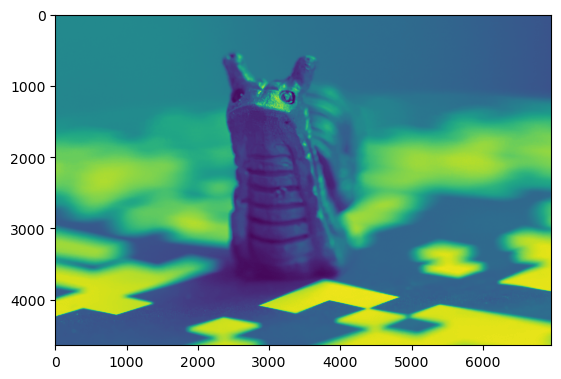

In [65]:
plt.imshow(stacks[0].pyramids[0].levels[0]['image'])

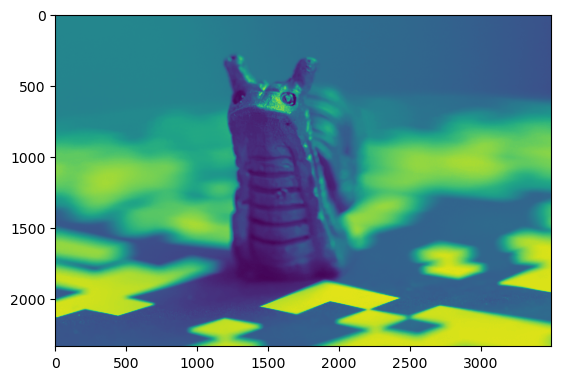

In [38]:
plt.imshow(stacks[0].pyramids[0].levels[1]['image'])

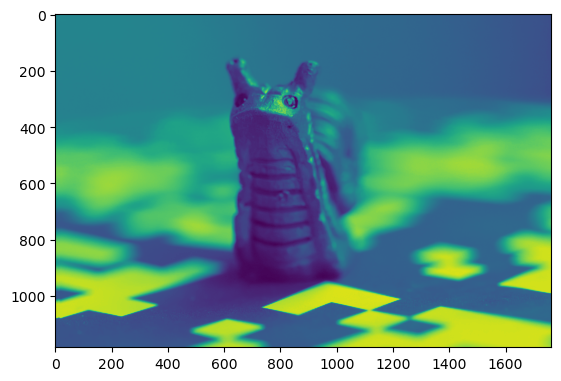

In [39]:
plt.imshow(stacks[0].pyramids[0].levels[2]['image'])

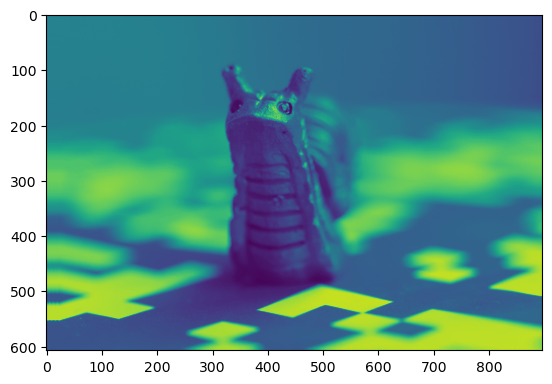

In [40]:
plt.imshow(stacks[0].pyramids[0].levels[3]['image'])

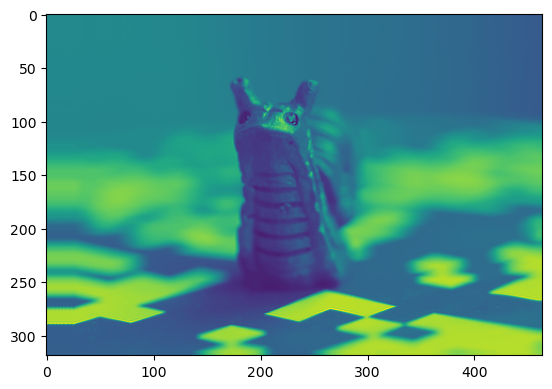

In [41]:
plt.imshow(stacks[0].pyramids[0].levels[4]['image'])

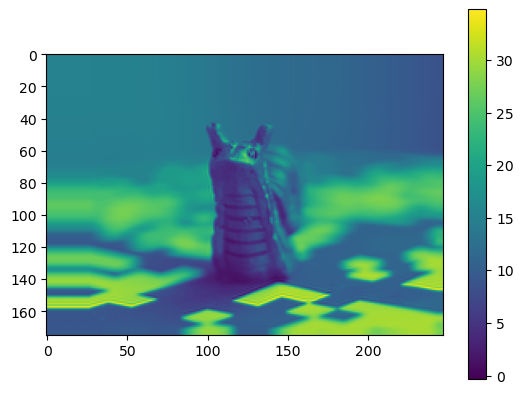

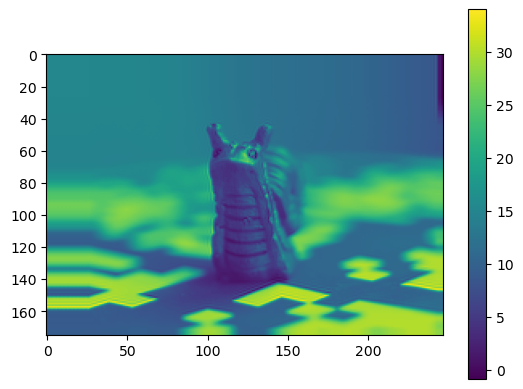

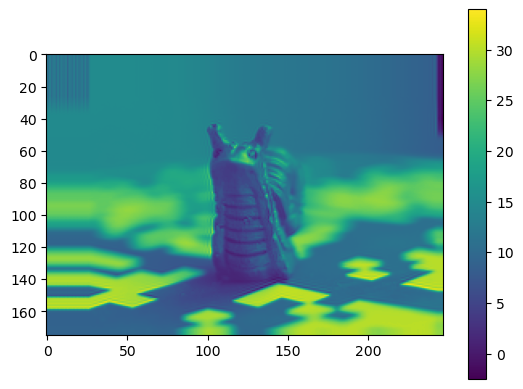

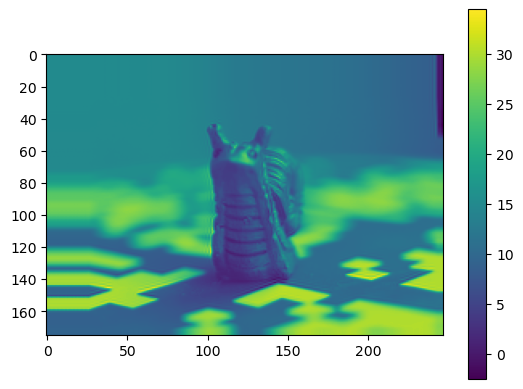

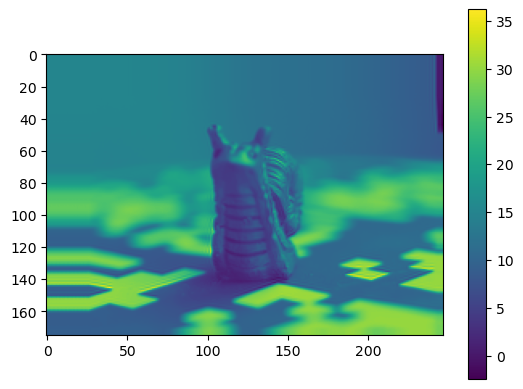

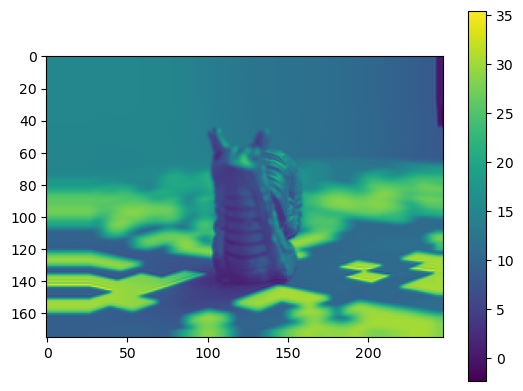

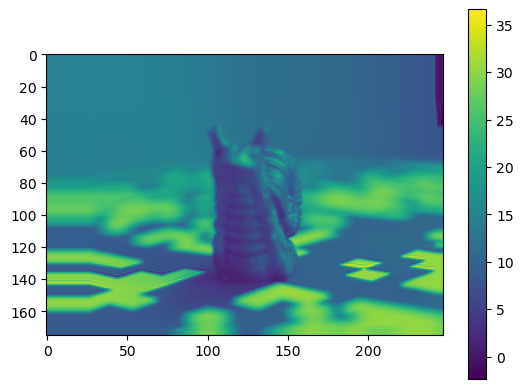

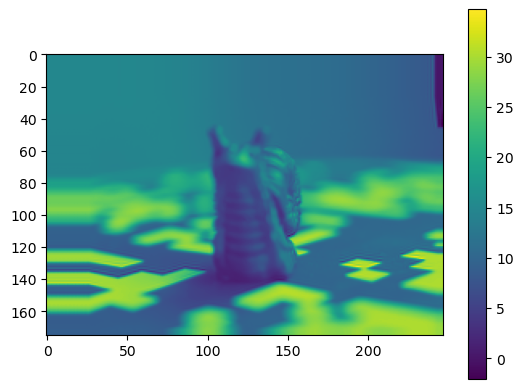

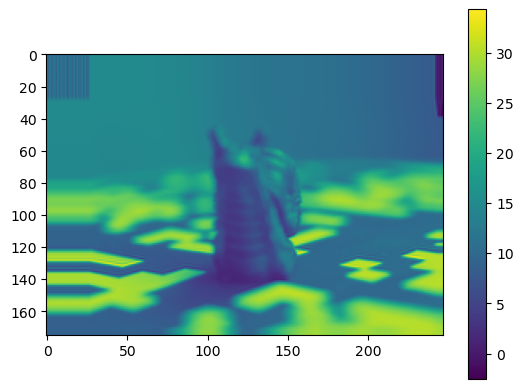

In [52]:
for i in range(len(stacks[0].pyramids)): 
    plt.imshow(stacks[0].pyramids[i].levels[5]['image'])
    plt.colorbar()
    plt.show()

In [49]:
for i in range(len(stacks[0].pyramids)):
    print(stacks[0].pyramids[i].levels[5]['image'].min(), stacks[0].pyramids[i].levels[5]['image'].max())

-0.32637498 34.813423
-0.8943717 34.046585
-2.5000317 33.97157
-2.501722 34.48514
-2.4254525 36.193558
-2.2981231 35.391766
-2.3370662 36.6126
-2.040616 34.69309
-2.537203 34.352707


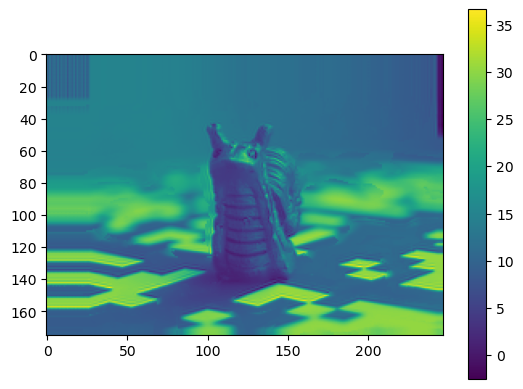

In [51]:
plt.imshow(recon_pyramids[0].levels[-1]['image'])
plt.colorbar()

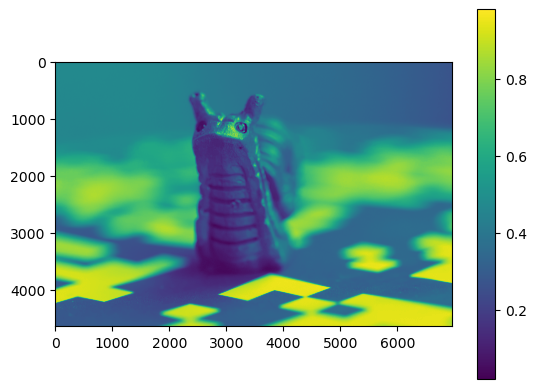

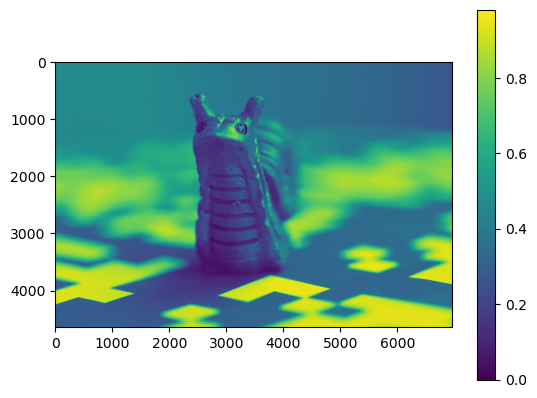

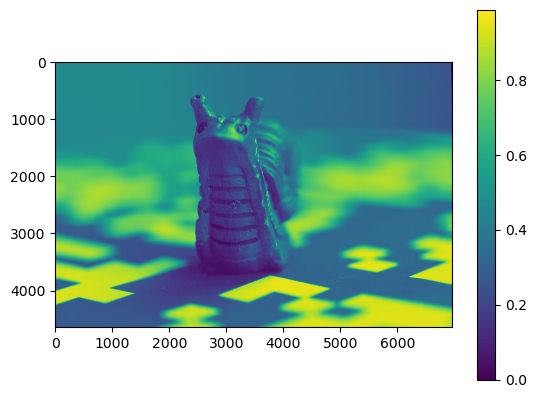

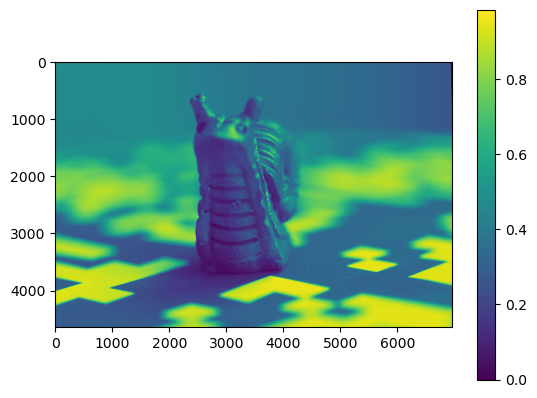

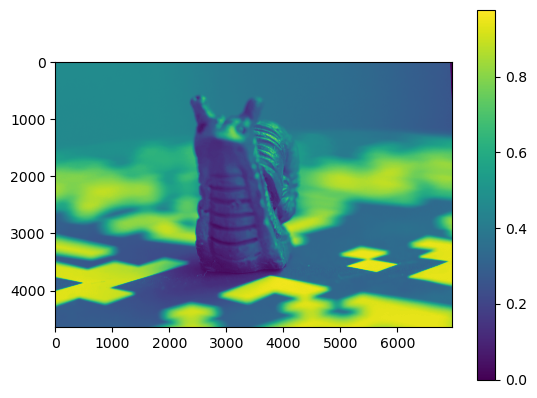

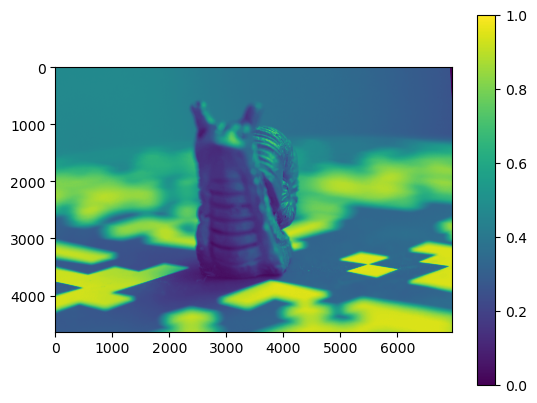

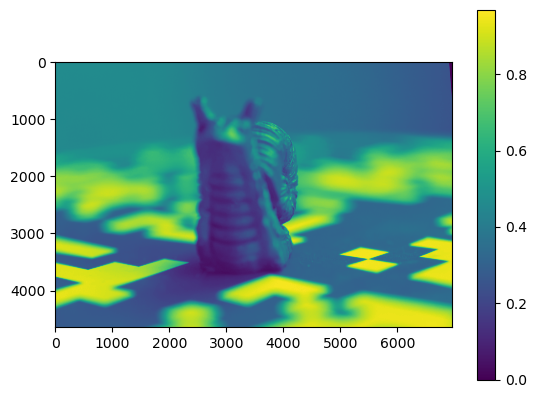

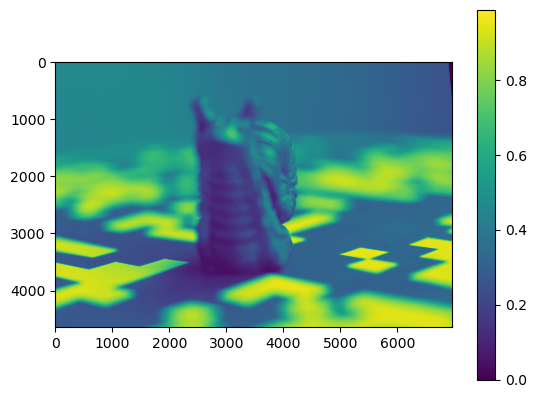

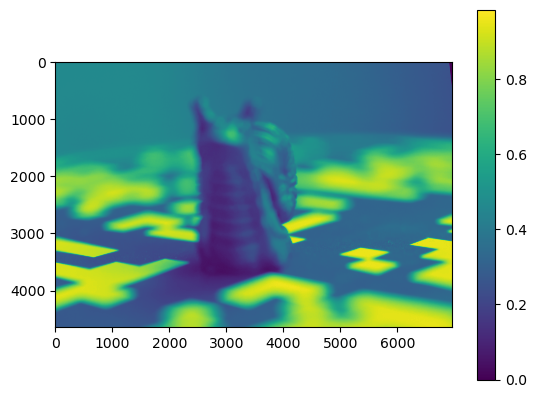

In [55]:
for i in range(len(stacks[0].pyramids)):
    recon = stacks[0].pyramids[i].reconstruct()
    plt.imshow(recon)
    plt.colorbar()
    plt.show()

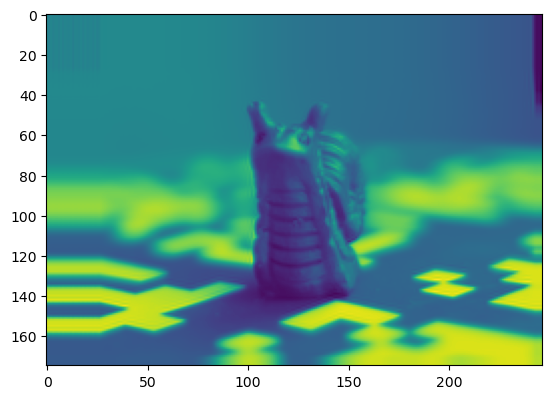

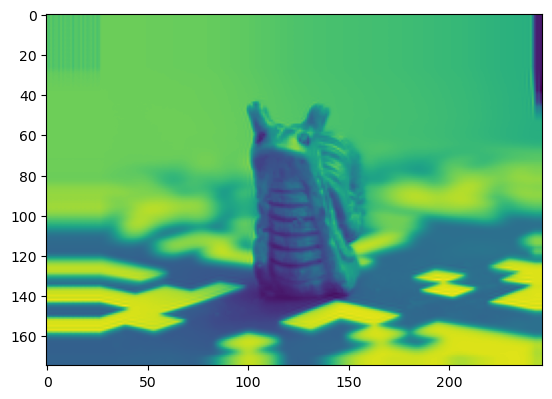

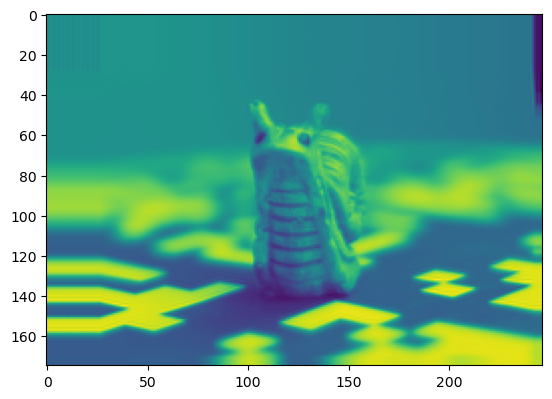

In [62]:
for i in range(3):
    plt.imshow(recon_pyramids[i].levels[-1]['image'])
    plt.show()

/tmp/ipykernel_2951935/3966030759.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(stacks[0].pyramids[4].levels[0]['HL_squared']))


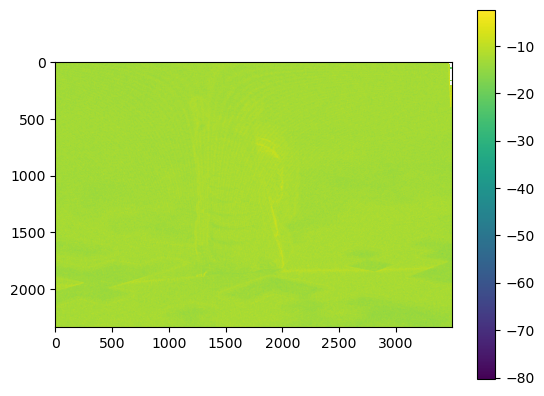

In [36]:
import numpy as np
plt.imshow(np.log(stacks[0].pyramids[4].levels[0]['HL_squared']))
plt.colorbar()

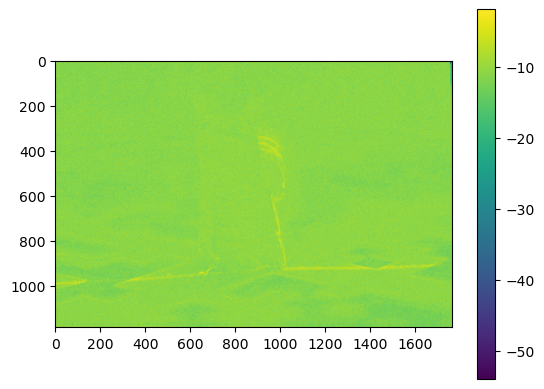

In [35]:
import numpy as np
plt.imshow(np.log(stacks[0].pyramids[4].levels[1]['LH_squared']))
plt.colorbar()

In [64]:
cv2.imwrite('/n/fs/3d-indoor/macro_data/focus_stacks/snail/000/f4.0/results/wavelet_mine.png', fused_im)

True

In [10]:
cmd_line = ['--data.obj', 'snail',
            '--data.view', '000',
            '--data.fnum', 'f4.0',
            '--pipeline', 'scale_transform',
            '--scale_transform.type', 'wavelet',
            '--scale_transform.wavelet_name', 'db16',
            '--scale_transform.depth', '2',
            '--scale_transform.base_energies', 'local_variance', 'local_entropy',
            '--scale_transform.base_fusion', 'multi_max',
            '--scale_transform.level_energies', 'squared',
            '--scale_transform.level_fusion', 'multi_max',
            '--energy.variance.neighborhood', '9',
            '--energy.entropy.neighborhood', '9',
            '--aux_out_dir', '/n/fs/3d-indoor/tmp_outdir/aux',
            ]
args = parser.parse_args(cmd_line)

In [15]:
fused_im_no_vote, stacks = scale_transform.run_wavelet_pipeline(args, registered_images)

wavelet
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
(array([   0,    0,    0, ..., 2334, 2334, 2334]), array([  33,   35,   55, ..., 3483, 3487, 3489]))
(array([   0,    0,    0, ..., 2334, 2334, 2334]), array([   5,    6,   14, ..., 3479, 3486, 3487]))
(array([   0,    0,    0, ..., 2334, 2334, 2334]), array([   0,    9,   30, ..., 3485, 3487, 3491]))
(array([   0,    0,    0, ..., 1182, 1182, 1182]), array([   4,   33,   39, ..., 1756, 1757, 1762]))
(array([   0,    0,    0, ..., 1182, 1182, 1182]), array([  18,   28,   32, ..., 1748, 1749, 1752]))
(array([   0,    0,    0, ..., 1182, 1182, 1182]), array([   0,    1,    2, ..., 1719, 1730, 1737]))
(1183, 1763) (1183, 1763) (1183, 1763)
(2335, 3495) (2335, 3495) (2335, 3495)
wavelet
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
making pyramid
(array([   0,    0,    0, ...,

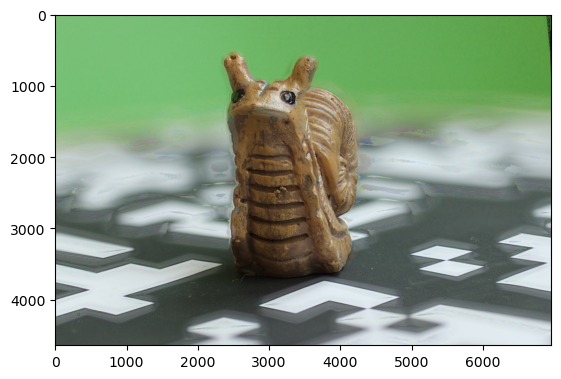

In [12]:
plt.imshow(im_utils.bgr_to_rgb(fused_im))

In [17]:
(fused_im_no_vote == fused_im).all()

True